____Ноутбук с генерации статей на основе оригинальных новостей The Guardian. Используется модель DeepSeek-v3 (API)____


* 1. Инициализация и загрузка данных

* 2. Генерация статей

* 3. Анализ сгенерированных статей

* 4. Доработка статей на основе фидбека модели, итерация 1

* 5. Доработка статей на основе фидбека модели, итерация 2

* 6. Доработка статей на основе фидбека модели, итерация 3

* 7. Обработка всех статей (полный цикл)

* 8. Сравнение оригинальных статей и сгенерирвоанных 

In [7]:
from utils_create_news import  save_s3, try_load, clean_titile_space
from IPython.display import clear_output
from utils_create_news import try_load
from dotenv import load_dotenv
from openai import OpenAI
from minio import Minio

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import string
import os
import re

# 1. Инициализация и загрузка данных

In [2]:
load_dotenv()

DEEPSEEK_API_KEY = os.getenv("DEEPSEEK_API_KEY")
YANDEX_CLOUD_ACCESS_KEY = os.getenv("AWS_ACCESS_KEY_ID")
YANDEX_CLOUD_SECRET_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")

BUCKET_NAME = 'graduate' # s3

PATH = '/Users/dan/git_repo/graduate/'

In [3]:
# DeepSeek client
client = OpenAI(api_key=DEEPSEEK_API_KEY, base_url="https://api.deepseek.com")

In [3]:
client_s3 = Minio(
    "storage.yandexcloud.net",
    access_key=YANDEX_CLOUD_ACCESS_KEY,
    secret_key=YANDEX_CLOUD_SECRET_KEY,
    secure=True
)

In [5]:
# Загрузим оригинальные новости
paper_dict = try_load(file_path=PATH+'data/', file_name='the_guardian_politic_CLEAN_news_09022025.pkl', client_s3=client_s3)
len(paper_dict)

5200

In [28]:
# Загрузим оригинальные новости
deepseek_api_clear_orig_news = try_load(file_path=PATH+'data/', file_name='deepseek_api_clear_orig_news.pkl', client_s3=client_s3)
len(deepseek_api_clear_orig_news)

3898

# 2. Генерация статей

In [ ]:
from models.deepseekv3 import dsv3_rewrite_news

In [12]:
keys = list(paper_dict.keys())
error_key = []

# Ранее переписанные новости deepseek 
deepseek_api_texts = try_load(file_path=PATH+'data/', file_name='deepseek_api_rewrite_texts.pkl', client_s3=client_s3)

for i, key in enumerate(keys):

    if key not in deepseek_api_texts.keys():
        try:
            print(f'---START {i}---')

            paper = paper_dict[key][0]
            question = paper_dict[key][1]

            question = question[:9000]

            ans = dsv3_rewrite_news(client=client, query=question)
            ans = ans.choices[0].message.content

            clear_output(wait=True)

            deepseek_api_texts[key] = [paper, ans]

            print(f'---START {i}---')

            print('Новость номер 1:')
            print(question)

            print('Новость номер 2:')
            print(ans)

            if len(deepseek_api_texts) % 25 == 0:

                save_s3(pickle_data=deepseek_api_texts, object_key='deepseek_api_rewrite_texts.pkl', client_s3=client_s3)

                with open(PATH+'/data/deepseek_api_rewrite_texts.pkl', 'wb') as file: 
                    pickle.dump(deepseek_api_texts, file)
                
        except:
            error_key.append(key)


---START 5199---
Новость номер 1:
The﻿ Metropolitan police have indicated that the dropped Conservative candidate Craig Williams could come under the scope of a criminal investigation into betting on the election that has overshadowed Rishi Sunak’s campaign. Scotland Yard will investigate any suspicious bets that could represent a misconduct in public office offence, while the Gambling Commission will continue to look at whether betting rules were broken. The prime minister repeatedly refused to say whether he told Williams, his closest parliamentary aide, about the date of the election, wrongly claiming he could prejudice the watchdog’s inquiry. So far, five Conservatives are known to have been caught up in the Gambling Commission inquiry since the Guardian revealed two weeks ago that Williams had placed a £100 bet with Ladbrokes three days before Sunak announced the date. Related: Who’s who of the people linked to the general election betting scandal The Tories have withdrawn the par

In [13]:
save_s3(pickle_data=deepseek_api_texts, object_key='deepseek_api_rewrite_texts.pkl', client_s3=client_s3)

with open(PATH+'/data/deepseek_api_rewrite_texts.pkl', 'wb') as file: 
    pickle.dump(deepseek_api_texts, file)

# 3. Анализ сгенерированных статей

### 3.1 Анализ глазами + LLM as a judge

In [17]:
# Сгенерированные статьи
for i, key in enumerate(list(deepseek_api_texts.keys())[3000:3005]):

    txt = deepseek_api_texts[key][1]
    print(f'Paper {i}: ', txt.replace('\n', ' '))

Paper 0:  The recent decision by the Home Office and Home Secretary Suella Braverman to bar Siyabonga Twala from returning to the UK has sparked outrage and raised serious questions about institutional racism within the country’s immigration policies. Twala, who has a spent conviction for a minor offense—one that he has not repeated—has been left stranded in Turkey, separated from his nine-year-old son and the life he built in Britain. Critics argue that the use of legislation designed to exclude dangerous criminals in this case is not only disproportionate but indicative of systemic bias against Black and minority ethnic individuals.    Legal experts and human rights advocates have condemned the decision, pointing out the stark contrast in how the justice system treats individuals based on race and class. While middle-class and celebrity drug offenses often go unpunished or are dismissed with minimal consequences, Twala’s case highlights the punitive measures disproportionately applie

In [11]:
# Сравнение статей оригинальных от сгенерировванных
for key in list(deepseek_api_texts.keys())[1000:1005]:

    txt = deepseek_api_texts[key][1]
    print('Статья 1:')
    print(txt.replace('\n', ' '))

    txt = paper_dict[key][1]
    print('Статья 2:')
    print(txt.replace('\n', ' '))
    
    print('\n')

Статья 1:
The Conservative Party is facing yet another scandal as Lancashire police prepare to contact suspended MP Mark Menzies following explosive allegations that campaign funds were misused to pay off individuals described as "bad people." The controversy has sent shockwaves through Westminster, with Labour leader Keir Starmer demanding a full police investigation and questioning why the Conservative Party took months to act on the claims.    Menzies, who represents Fylde and previously served as a government trade envoy to several South American countries, was suspended by the Conservative Party after reports surfaced that he allegedly pressured an aide to hand over thousands of pounds in the middle of the night to resolve a personal crisis. According to *The Times*, Menzies reportedly called his former campaign manager—now a party volunteer—at 3:15 a.m. in December, claiming he was being held in a flat by "bad people" and urgently needed £5,000 for what he described as a "life an

### **1. Стилистические особенности, характерные для LLM:**
- **Чрезмерная структурированность** – абзацы выглядят как логически завершенные блоки с четким вступлением, развитием и выводом (как в эссе).
- **Обобщенные формулировки** – фразы вроде *"Critics argue that..."*, *"Legal experts and human rights advocates have condemned..."*, *"Campaigners argue that..."* – типичный прием LLM для балансировки точки зрения.
- **Повторение ключевых тезисов** – например, в Paper 0 несколько раз подчеркивается тема институционального расизма, а в Paper 1 – конфликт внутри Консервативной партии.

### **2. Отсутствие конкретных деталей, характерных для реальных журналистских материалов:**
- **Нет имен конкретных критиков** (кроме Dr. Wanda Wyporska в Paper 0 и Claire Bullivant в Paper 1). В реальных статьях чаще цитируют нескольких экспертов или прямые заявления.
- **Нет ссылок на официальные документы или прямые цитаты из законов** (например, в Paper 0 упоминается "1999 Macpherson report", но без конкретной выдержки).
- **Нет уникальных фактов или глубокого анализа** – оба текста скорее обобщают ситуацию, чем исследуют её.

### **3. Нейтральный, но слегка шаблонный тон:**
- Все текста избегают резких оценок, сохраняя "умеренно критический" тон, что типично для LLM (чтобы избежать предвзятости).
- В Paper 1 есть фразы вроде *"The controversy comes at a delicate time for Sunak..."* – это клишированный переход, часто встречающийся в генерациях.

### **4. Отсутствие авторского стиля:**
- Настоящие журналистские материалы часто содержат:
  - эмоциональные или саркастические комментарии,
  - уникальные метафоры,
  - личные наблюдения,
  - ссылки на предыдущие публикации издания.
- Здесь же текст звучит как "универсальный пересказ событий".

### **Вывод:**

Статьи можно улучшить, добавив:  
- конкретные цитаты,  
- более резкие/неоднозначные мнения,  
- элементы авторского стиля.  

### 3.2 Анализ длинны статей

In [14]:
cnt_len_memmory = []
for paper in deepseek_api_texts.values():
    paper = paper[1]
    cnt_len_memmory.append(
        len(paper.split(' '))
    )

cnt_len_memmory = pd.Series(cnt_len_memmory)

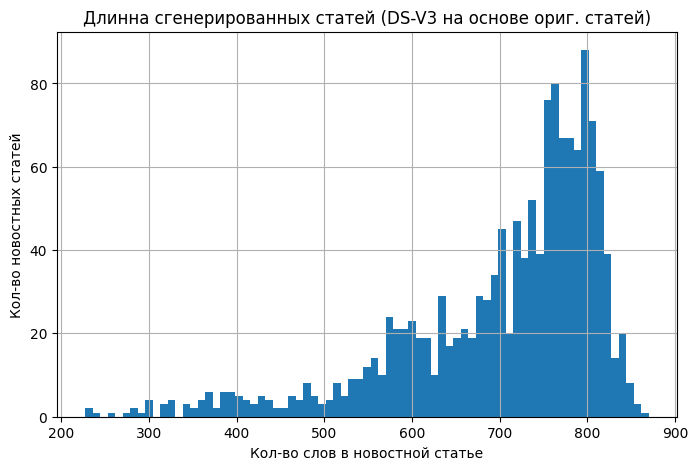

In [15]:
plt.figure(figsize=(8,5))

cnt_len_memmory.hist(bins=75)

plt.title('Длинна сгенерированных статей (DS-V3 на основе ориг. статей)')

plt.xlabel('Кол-во слов в новостной статье')
plt.ylabel('Кол-во новостных статей')

plt.show()

In [16]:
dsv3_mean, dsv3_median, dsv3_q05, dsv3q95 = cnt_len_memmory.mean(), cnt_len_memmory.median(), cnt_len_memmory.quantile(0.05), cnt_len_memmory.quantile(0.95)
print('Generated paper')
print(f'Среднее: {dsv3_mean:.2f}, медиана: {dsv3_median:.2f}, квантиль 0,05: {dsv3_q05:.2f}, квантиль 0,95: {dsv3q95:.2f}')

Generated paper
Среднее: 702.49, медиана: 741.00, квантиль 0,05: 444.85, квантиль 0,95: 822.00


# 4. Доработка статей на основе фидбека модели, итерация 1

**https://arxiv.org/pdf/2303.17651**

In [38]:
from models.deepseekv3 import dsv3_evaluate_dsv3_paper, dsv3_rewrite_dsv3_paper

## 4.1 Пример

In [34]:
key = 'politics/2023/jul/27/independent-scotland-base-citizenship-on-irish-model'
print(deepseek_api_texts[key][1].replace('\n', ''), '\n')

# Оценка
eval_paper = dsv3_evaluate_dsv3_paper(client=client, query=deepseek_api_texts[key][1])
eval_paper = eval_paper.choices[0].message.content
print(eval_paper)

# Редактирование
final_paper = dsv3_rewrite_dsv3_paper(client=client, news_article=deepseek_api_texts[key][1], suggestions=eval_paper)
final_paper = final_paper.choices[0].message.content

print(final_paper.replace('\n', ''))

The Scottish government has unveiled ambitious proposals outlining how citizenship would function in an independent Scotland, drawing inspiration from Ireland’s inclusive model. First Minister Humza Yousaf presented the plans, which aim to simplify the citizenship process by removing mandatory tests and drastically lowering application fees—a stark contrast to the UK government’s stricter immigration policies. The announcement has reignited tensions between Edinburgh and Westminster, particularly over whether Scottish taxpayer funds should be allocated to preparations for potential independence.  The document, part of the "Building a New Scotland" series initiated by former First Minister Nicola Sturgeon, advocates for a citizenship framework that would automatically grant Scottish nationality to individuals born abroad if at least one parent holds Scottish citizenship. This approach mirrors Ireland’s system, which has long been praised for its flexibility and inclusivity. Additionally

In [19]:
deepseek_api_texts = try_load(file_path=PATH+'data/', file_name='deepseek_api_rewrite_texts.pkl', client_s3=client_s3)
keys = list(deepseek_api_texts.keys())
error_key = []

# Ранее переписанные новости deepseek 
deepseek_api_iterative_refinement = try_load(file_path=PATH+'data/', file_name='deepseek_api_iterative_refinement.pkl', client_s3=client_s3)

for i, key in enumerate(keys):

    if key not in deepseek_api_iterative_refinement.keys():
        try:
            print(f'---START {i}---')

            # Статья для обработки
            paper = deepseek_api_texts[key][1]
            print('Статья до изменений:', paper)

            # Оценка статьи
            eval_paper = dsv3_evaluate_dsv3_paper(client=client, query=paper)
            eval_paper = eval_paper.choices[0].message.content.replace('\n', '')
            print('Оценка статьи:', eval_paper)

            # Редактирование
            final_paper = dsv3_rewrite_dsv3_paper(client=client, news_article=paper, suggestions=eval_paper)
            final_paper = final_paper.choices[0].message.content.replace('\n', '')
            print(final_paper)

            clear_output(wait=True)

            deepseek_api_iterative_refinement[key] = [eval_paper, final_paper]

            print(f'---START {i}---')

            print('Статья до изменений:', paper)
            print('Оценка статьи:', eval_paper)
            print('итоговая статья:', final_paper)

            if len(deepseek_api_iterative_refinement) % 25 == 0:

                save_s3(pickle_data=deepseek_api_iterative_refinement, object_key='deepseek_api_iterative_refinement.pkl', client_s3=client_s3)

                with open(PATH+'/data/deepseek_api_iterative_refinement.pkl', 'wb') as file: 
                    pickle.dump(deepseek_api_iterative_refinement, file)
                
        except:
            error_key.append(key)


---START 482---
Статья до изменений: The Liberal Democrats are set to make a bold push to eliminate voter ID requirements, framing the policy as a deliberate attack on younger voters by the Conservative Party. The party plans to include this pledge in their upcoming election manifesto, arguing that the policy is not only expensive but also unnecessary, as it attempts to solve a virtually non-existent problem while disproportionately disenfranchising young people.  Since its introduction in May 2023 by the Conservative government, the voter ID law has mandated that all eligible voters present photo identification—such as passports, driving licenses, or certain travel cards—before casting their ballots in general, local, or police and crime commissioner elections. However, critics have pointed out glaring inconsistencies in the policy. While older voters can use 60-plus Oyster cards as valid ID, younger individuals are barred from using their own Oyster cards, raising concerns that the r

In [15]:
with open(PATH+'/data/deepseek_api_iterative_refinement.pkl', 'wb') as file: 
    pickle.dump(deepseek_api_iterative_refinement, file)

save_s3(pickle_data=deepseek_api_iterative_refinement, object_key='deepseek_api_iterative_refinement.pkl', client_s3=client_s3)

In [14]:
len(deepseek_api_iterative_refinement)

575

# 5. Доработка статей на основе фидбека модели, итерация 2

In [39]:
from models.deepseekv3 import dsv3_evaluate_dsv3_paper_v2, dsv3_rewrite_dsv3_paper_v2

In [27]:
key = 'politics/article/2024/jun/21/labour-drafts-options-for-wealth-taxes-to-unlock-funds-for-public-services'
print('Статья до обработки:', deepseek_api_iterative_refinement[key][1].replace('\n', ''), '\n')

# Оценка
eval_paper = dsv3_evaluate_dsv3_paper_v2(client=client, generated_article=deepseek_api_iterative_refinement[key][1], original_query=deepseek_api_clear_orig_news[key][1])
eval_paper = eval_paper.choices[0].message.content
print('Замечания к статье', eval_paper)

# Редактирование
final_paper = dsv3_rewrite_dsv3_paper_v2(client=client, news_article=deepseek_api_iterative_refinement[key][1], suggestions=eval_paper)
final_paper = final_paper.choices[0].message.content
print('Итог обработки:', final_paper.replace('\n', ''))

Статья до обработки: The rolling hills of England’s countryside may soon become the unlikely battleground for Labour’s most ambitious tax reforms in decades. With the party poised for potential victory, shadow ministers are quietly drafting plans to overhaul Britain’s wealth taxes—measures that could reshape everything from family farms to City investment portfolios.At the heart of the proposals lies a dual approach: raising capital gains tax (CGT) rates and closing inheritance tax loopholes that have long benefited wealthy landowners. Internal Labour documents seen by the Guardian reveal these changes could generate £10 billion annually—funds desperately needed to shore up crumbling public services."Farmland shouldn’t be a tax avoidance vehicle for millionaires while nurses use food banks," argues Dr. Arun Advani, an economist at Warwick University whose research informed Labour’s plans. His 2022 study found agricultural relief allows landowners to avoid £700 million yearly in inherit

In [36]:
import numpy as np
keys_intersect = np.intersect1d(
    np.array(list(deepseek_api_clear_orig_news.keys())), 
    np.array(list(deepseek_api_iterative_refinement.keys()))
    )

len(keys_intersect)

466

In [37]:
error_key = []

# Ранее переписанные новости deepseek 
# deepseek_api_iterative_refinement = try_load(file_path=PATH+'data/', file_name='deepseek_api_iterative_refinement.pkl', client_s3=client_s3)
deepseek_api_iterative_refinement_2 = {}

for i, key in enumerate(keys_intersect):

    if key not in deepseek_api_iterative_refinement_2.keys():
        try:
            print(f'---START {i}---')

            # Статья для обработки
            paper = deepseek_api_texts[key][1]
            print('Статья до изменений:', paper)

            # Оценка статьи
            eval_paper = dsv3_evaluate_dsv3_paper_v2(client=client, generated_article=deepseek_api_iterative_refinement[key][1], original_query=deepseek_api_clear_orig_news[key][1])
            eval_paper = eval_paper.choices[0].message.content
            print('Замечания к статье', eval_paper)

            # Редактирование
            final_paper = dsv3_rewrite_dsv3_paper_v2(client=client, news_article=deepseek_api_iterative_refinement[key][1], suggestions=eval_paper)
            final_paper = final_paper.choices[0].message.content.replace('\n', '')
            print('Итог обработки:', final_paper)

            clear_output(wait=True)

            deepseek_api_iterative_refinement_2[key] = [eval_paper, final_paper]

            print(f'---START {i}---')

            print('Статья до изменений:', paper)
            print('Оценка статьи:', eval_paper)
            print('итоговая статья:', final_paper)

            if len(deepseek_api_iterative_refinement_2) % 25 == 0:

                save_s3(pickle_data=deepseek_api_iterative_refinement_2, object_key='deepseek_api_iterative_refinement_2.pkl', client_s3=client_s3)

                with open(PATH+'/data/deepseek_api_iterative_refinement_2.pkl', 'wb') as file: 
                    pickle.dump(deepseek_api_iterative_refinement_2, file)
                
        except:
            error_key.append(key)

---START 465---
Статья до изменений: The tranquil beauty of Fawley Meadows along the River Thames belies a growing crisis beneath its surface. On a breezy late spring day, Dave Wallace, a former open-water swimmer turned environmental activist, wades into the river’s murky waters with a sampling beaker in hand. The scene is picturesque—red kites circling overhead, the historic Henley Bridge framing the horizon—but Wallace knows better than to be fooled by appearances. His once-beloved swimming spot has become a battleground against pollution, a fight he never expected to join until a disturbing encounter two summers ago.  Wallace recalls the moment his perspective shifted. During the Henley to Marlow marathon swim, the river’s sluggish flow and unnerving clarity revealed an unsettling truth. "The water was stagnant, and I could see brown streaks swirling around me," he says. "It hit me—I was swimming in sewage. That was the day I stopped seeing the Thames as just a place for recreation

In [47]:
key = str(keys_intersect[-2])

print(f'Статья до изменений: {deepseek_api_iterative_refinement[key][0]}')
print(f'Замечания: {deepseek_api_iterative_refinement_2[key][0]}')
print(f'Статья после изменений: {deepseek_api_iterative_refinement_2[key][1]}')


Статья до изменений: 1) Add direct quotes from named Conservative MPs or party insiders to provide insider perspectives on the potential upheaval.  2) Replace generic terms like "political analysts" with specific names and affiliations to enhance credibility.  3) Introduce a human-interest angle, such as profiling a long-serving Conservative MP facing a tough re-election battle.  4) Vary sentence structure to avoid repetitive patterns (e.g., "First... Second...").  5) Include counterarguments or optimistic Conservative viewpoints to balance the narrative.  6) Strengthen transitions between paragraphs to improve flow (e.g., connect polling data to voter sentiment more smoothly).  7) Break the long second paragraph into shorter, more digestible segments.  8) Add vivid descriptors or anecdotes about key constituencies (e.g., Bristol Central) to ground the analysis.  9) Use less formal phrasing in parts (e.g., "paints a stark picture" could be more conversational).  10) Open with a compell

In [39]:
print('Статья до изменений:', paper)
print('Оценка статьи:', eval_paper)
print('итоговая статья:', final_paper)

Статья до изменений: The tranquil beauty of Fawley Meadows along the River Thames belies a growing crisis beneath its surface. On a breezy late spring day, Dave Wallace, a former open-water swimmer turned environmental activist, wades into the river’s murky waters with a sampling beaker in hand. The scene is picturesque—red kites circling overhead, the historic Henley Bridge framing the horizon—but Wallace knows better than to be fooled by appearances. His once-beloved swimming spot has become a battleground against pollution, a fight he never expected to join until a disturbing encounter two summers ago.  Wallace recalls the moment his perspective shifted. During the Henley to Marlow marathon swim, the river’s sluggish flow and unnerving clarity revealed an unsettling truth. "The water was stagnant, and I could see brown streaks swirling around me," he says. "It hit me—I was swimming in sewage. That was the day I stopped seeing the Thames as just a place for recreation and started see

In [38]:
save_s3(pickle_data=deepseek_api_iterative_refinement_2, object_key='deepseek_api_iterative_refinement_2.pkl', client_s3=client_s3)

with open(PATH+'/data/deepseek_api_iterative_refinement_2.pkl', 'wb') as file: 
    pickle.dump(deepseek_api_iterative_refinement_2, file)

# 6. Доработка статей на основе фидбека модели, итерация 3

In [40]:
from models.deepseekv3 import dsv3_evaluate_dsv3_paper_v3, dsv3_rewrite_dsv3_paper_v3

In [57]:
key = 'politics/article/2024/jun/21/labour-drafts-options-for-wealth-taxes-to-unlock-funds-for-public-services'
print('Статья до обработки:', deepseek_api_iterative_refinement_2[key][1].replace('\n', ''), '\n')

# Оценка
eval_paper = dsv3_evaluate_dsv3_paper_v3(client=client, generated_article=deepseek_api_iterative_refinement_2[key][1])
eval_paper = eval_paper.choices[0].message.content
print('Замечания к статье:', eval_paper, '\n')

# Редактирование
final_paper = dsv3_rewrite_dsv3_paper_v3(client=client, news_article=deepseek_api_iterative_refinement_2[key][1], suggestions=eval_paper)
final_paper = final_paper.choices[0].message.content
print('Итог обработки:', final_paper.replace('\n', ''))

Статья до обработки: Labour is considering significant reforms to capital gains and inheritance taxes as part of its fiscal planning ahead of the next general election, according to policy documents reviewed by the Guardian.  The proposals, still under internal discussion, focus on two key areas: raising capital gains tax (CGT) rates and scaling back inheritance tax reliefs for agricultural and business assets. Treasury estimates suggest the changes could generate up to £10 billion annually.  Under the plans, CGT rates for higher earners could rise substantially, with the top rate potentially increasing from 20% to between 30% and 35%. Basic-rate taxpayers would see a smaller adjustment, with rates possibly climbing from 10% to 15-18%.  The inheritance tax reforms target Agricultural Property Relief and Business Property Relief, which currently offer exemptions of up to 100%. Shadow Chancellor Rachel Reeves has floated capping these reliefs at £500,000 per individual, or £1 million whe

In [58]:
error_key = []

# Ранее переписанные новости deepseek 
# deepseek_api_iterative_refinement = try_load(file_path=PATH+'data/', file_name='deepseek_api_iterative_refinement.pkl', client_s3=client_s3)
deepseek_api_iterative_refinement_3 = {}

for i, key in enumerate(keys_intersect):

    if key not in deepseek_api_iterative_refinement_3.keys():
        try:
            print(f'---START {i}---')

            # Статья для обработки
            paper = deepseek_api_iterative_refinement_2[key][1]
            print('Статья до изменений:', paper)

            # Оценка статьи
            eval_paper = dsv3_evaluate_dsv3_paper_v3(client=client, generated_article=paper)
            eval_paper = eval_paper.choices[0].message.content
            print('Замечания к статье', eval_paper)

            # Редактирование
            final_paper = dsv3_rewrite_dsv3_paper_v3(client=client, news_article=paper, suggestions=eval_paper)
            final_paper = final_paper.choices[0].message.content.replace('\n', '')
            print('Итог обработки:', final_paper)

            clear_output(wait=True)

            deepseek_api_iterative_refinement_3[key] = [eval_paper, final_paper]

            print(f'---START {i}---')

            print('Статья до изменений:', paper)
            print('Оценка статьи:', eval_paper)
            print('итоговая статья:', final_paper)

            if len(deepseek_api_iterative_refinement_3) % 25 == 0:

                save_s3(pickle_data=deepseek_api_iterative_refinement_3, object_key='deepseek_api_iterative_refinement_3.pkl', client_s3=client_s3)

                with open(PATH+'/data/deepseek_api_iterative_refinement_3.pkl', 'wb') as file: 
                    pickle.dump(deepseek_api_iterative_refinement_3, file)
                
        except:
            error_key.append(key)

save_s3(pickle_data=deepseek_api_iterative_refinement_3, object_key='deepseek_api_iterative_refinement_3.pkl', client_s3=client_s3)

with open(PATH+'/data/deepseek_api_iterative_refinement_3.pkl', 'wb') as file: 
    pickle.dump(deepseek_api_iterative_refinement_3, file)

---START 465---
Статья до изменений: **The Thames Under Threat: A River's Struggle Against Pollution**  On a brisk May morning, environmental activist Dave Wallace wades into the Thames near Fawley Meadows, the sharp wind rippling the water’s surface as he fills a sampling beaker. The scene appears idyllic—red kites circling above, the historic Henley Bridge framing the view—but Wallace knows the river’s condition tells a different story.  "It was during the 2022 Henley to Marlow marathon swim that I realized something was wrong," Wallace recalls. "The water wasn’t just clear—it had an unnatural clarity, with visible streaks of sediment. That’s when it hit me: I was swimming in sewage."  His experience is far from unique. Along the Thames’ 215-mile course, from its source in the Cotswolds to its estuary at the North Sea, concerns over pollution have galvanized a growing coalition of anglers, scientists, and local residents. What began as isolated complaints has evolved into a coordinat

# 7. Обработка всех статей (полный цикл)

In [89]:
from models.deepseekv3 import (
    dsv3_rewrite_news, 
    dsv3_evaluate_dsv3_paper, 
    dsv3_rewrite_dsv3_paper, 
    dsv3_evaluate_dsv3_paper_v2, 
    dsv3_rewrite_dsv3_paper_v2,
    dsv3_evaluate_dsv3_paper_v3, 
    dsv3_rewrite_dsv3_paper_v3, 
    dsv3_rewrite_dsv3_paper_v5, 
    dsv3_rewrite_dsv3_paper_v6
)

In [43]:
# Оригинальная статья
the_guardian_clean_politic_news_03052025 = try_load(
    file_path=PATH+'data/',
    file_name='the_guardian_clean_politic_news_03052025.pkl',
    client_s3=client_s3
    )

In [79]:
# 1. Переписание статьи
the_guardian_clean_politic_news_03052025_keys = list(the_guardian_clean_politic_news_03052025.keys())
q = the_guardian_clean_politic_news_03052025[the_guardian_clean_politic_news_03052025_keys[0]][1]
print('1. [ID 0] Оригинальная статья:', q, '\n')
# ans_1 = dsv3_rewrite_news(client=client, query=q)
# ans_1 = ans_1.choices[0].message.content
ans_1 = ans_1.replace('\n\n', '\n')
print('2. [ID 1] Статя, написанная LLM на основе оригинальной:', ans_1, '\n')

# 3.1 Оценка статьи
# eval_paper_1 = dsv3_evaluate_dsv3_paper(client=client, query=ans_1)
# eval_paper_1 = eval_paper_1.choices[0].message.content.replace('\n', '')
print('3.1. [ID 2] Оценка статьи:', eval_paper_1)

# 3.2 Редактирования статьи
# edit_paper_1 = dsv3_rewrite_dsv3_paper(client=client, news_article=ans_1, suggestions=eval_paper_1)
# edit_paper_1 = edit_paper_1.choices[0].message.content.replace('\n\n', '\n')
edit_paper_1 = clean_titile_space(edit_paper_1)
print('3.2. [ID 3] Статья после второго изменения:', edit_paper_1, '\n')

# 4.1 Оценка статьи
# eval_paper_2 = dsv3_evaluate_dsv3_paper_v2(client=client, generated_article=edit_paper_1, original_query=q)
# eval_paper_2 = eval_paper_2.choices[0].message.content.replace('\n', '')
print('4.1. [ID 4] Замечания к статье:', eval_paper_2, '\n')

# 4.2 Редактирование статьи
# edit_paper_2 = dsv3_rewrite_dsv3_paper_v2(client=client, news_article=edit_paper_1, suggestions=eval_paper_2)
# edit_paper_2 = edit_paper_2.choices[0].message.content.replace('\n\n', '\n')
print('4.2. [ID 5] Статья после третьего изменения:', edit_paper_2, '\n')

# 5.1 Оценка статьи
# eval_paper_3 = dsv3_evaluate_dsv3_paper_v3(client=client, generated_article=edit_paper_2)
# eval_paper_3 = eval_paper_3.choices[0].message.content.replace('\n', '')
print('5.1. [ID 6] Замечания к статье', eval_paper_3, '\n')

# 5.2 Редактирование статьи
# edit_paper_3 = dsv3_rewrite_dsv3_paper_v3(client=client, news_article=edit_paper_2, suggestions=eval_paper_3)
# edit_paper_3 = edit_paper_3.choices[0].message.content.replace('\n\n', '\n')
print('5.2. [ID 7] Статья после четвертого изменения:', edit_paper_3, '\n')

# edit_paper_4 = dsv3_rewrite_dsv3_paper_v5(client=client, news_article=edit_paper_3)
# edit_paper_4 = edit_paper_4.choices[0].message.content.replace('\n\n', '\n')
print('6. [ID 8] Статья после пятого изменения:', edit_paper_4, '\n')

### 7. Редактивроание статьи - подгонка под новостную статью
# edit_paper_5 = dsv3_rewrite_dsv3_paper_v6(client=client, news_article=edit_paper_4)
# edit_paper_5 = edit_paper_5.choices[0].message.content.replace('\n\n', '\n')
edit_paper_5 = clean_titile_space(edit_paper_5)
print('7. [ID 9] Статья после пятого изменения:', edit_paper_5)

1. [ID 0] Оригинальная статья: A Reform UK activist in the constituency where Nigel Farage is standing has been secretly filmed making extremely racist comments about Rishi Sunak, as well as using Islamophobic and other offensive language.
Farage said he was “dismayed” by the views expressed by Andrew Parker, a Reform canvasser, who was filmed as part of an undercover investigation by Channel 4 News.
The channel also secretly filmed George Jones, a longtime party activist who organises events for Farage, making homophobic comments, calling the Pride flag “degenerate” and LGBT people “nonces”.
The emergence of the footage, filming of which concluded last week, comes on the same day that Reform dropped an election candidate in another seat, after the Guardian informed the party that Raymond Saint had been on a list of members of the British National party.
The most serious comments uncovered by Channel 4 News involved Parker, who was covertly filmed making them while canvassing and trave

In [30]:
deepseek_api_texts = try_load(file_path=PATH+'data/', file_name='deepseek_api_rewrite_texts.pkl', client_s3=client_s3)

In [108]:
# the_guardian_clean_politic_news_03052025_keys = list(the_guardian_clean_politic_news_03052025.keys())

dsv3_cycle_rewrite_from_orig = try_load(file_path=PATH+'data/', file_name='dsv3_cycle_rewrite_from_orig.pkl', client_s3=client_s3)

for i, key in enumerate(the_guardian_clean_politic_news_03052025_keys[:1000]):

        if key not in dsv3_cycle_rewrite_from_orig.keys():

                print(f'---START {i}---')

                ### 1. Оригинальная статья
                orig_paper = the_guardian_clean_politic_news_03052025[key][1]
                print('1. [ID 0] Оригинальная статья:', orig_paper, '\n')

                ### 2. Переписанная статья
                edit_paper_0 = dsv3_rewrite_news(client=client, query=orig_paper)
                edit_paper_0 = edit_paper_0.choices[0].message.content
                edit_paper_0 = edit_paper_0.replace('\n\n', '\n')
                print('2. [ID 1] Статя, написанная LLM на основе оригинальной:', edit_paper_0, '\n')

                ### 3. RF этап 1
                # 3.1 Оценка статьи
                eval_paper_1 = dsv3_evaluate_dsv3_paper(client=client, query=edit_paper_0)
                eval_paper_1 = eval_paper_1.choices[0].message.content.replace('\n', '')
                print('3.1. [ID 2] Оценка статьи:', eval_paper_1, '\n')

                # 3.2 Редактирования статьи
                edit_paper_1 = dsv3_rewrite_dsv3_paper(client=client, news_article=edit_paper_0, suggestions=eval_paper_1)
                edit_paper_1 = edit_paper_1.choices[0].message.content.replace('\n\n', '\n')
                edit_paper_1 = clean_titile_space(edit_paper_1)
                print('3.2. [ID 3] Статья после второго изменения:', edit_paper_1, '\n')

                ### 4. RF этап 2
                # 4.1 Оценка статьи
                eval_paper_2 = dsv3_evaluate_dsv3_paper_v2(client=client, generated_article=edit_paper_1, original_query=orig_paper)
                eval_paper_2 = eval_paper_2.choices[0].message.content.replace('\n', '')
                print('4.1. [ID 4] Замечания к статье:', eval_paper_2, '\n')

                # 4.2 Редактирование статьи
                edit_paper_2 = dsv3_rewrite_dsv3_paper_v2(client=client, news_article=edit_paper_1, suggestions=eval_paper_2)
                edit_paper_2 = edit_paper_2.choices[0].message.content.replace('\n\n', '\n')
                print('4.2. [ID 5] Статья после третьего изменения:', edit_paper_2, '\n')

                ### 5. RF этап 3
                # 5.1 Оценка статьи
                eval_paper_3 = dsv3_evaluate_dsv3_paper_v3(client=client, generated_article=edit_paper_2)
                eval_paper_3 = eval_paper_3.choices[0].message.content.replace('\n', '')
                print('5.1. [ID 6] Замечания к статье', eval_paper_3, '\n')

                # 5.2 Редактирование статьи
                edit_paper_3 = dsv3_rewrite_dsv3_paper_v3(client=client, news_article=edit_paper_2, suggestions=eval_paper_3)
                edit_paper_3 = edit_paper_3.choices[0].message.content.replace('\n\n', '\n')
                print('5.2. [ID 7] Статья после четвертого изменения:', edit_paper_3, '\n')

                ### 6. Редактивроание статьи - уход от аналитической записки
                edit_paper_4 = dsv3_rewrite_dsv3_paper_v5(client=client, news_article=edit_paper_3)
                edit_paper_4 = edit_paper_4.choices[0].message.content.replace('\n\n', '\n')
                print('6. [ID 8] Статья после пятого изменения:', edit_paper_4, '\n')

                ### 7. Редактивроание статьи - подгонка под новостную статью
                edit_paper_5 = dsv3_rewrite_dsv3_paper_v6(client=client, news_article=edit_paper_4)
                edit_paper_5 = edit_paper_5.choices[0].message.content.replace('\n\n', '\n')
                edit_paper_5 = clean_titile_space(edit_paper_5)
                print('7. [ID 9] Статья после шестого изменения:', edit_paper_5, '\n')

                dsv3_cycle_rewrite_from_orig[key] = [
                    orig_paper, edit_paper_0, eval_paper_1, edit_paper_1, eval_paper_2, edit_paper_2, eval_paper_3, edit_paper_3, edit_paper_4, edit_paper_5
                    ]

                clear_output(wait=True)

                print(f'---START {i}---')
                
                print('1. [ID 0] Оригинальная статья:', orig_paper, '\n')
                print('2. [ID 1] Статя, написанная LLM на основе оригинальной:', edit_paper_0, '\n')
                print('3.1. [ID 2] Оценка статьи:', eval_paper_1, '\n')
                print('3.2. [ID 3] Статья после второго изменения:', edit_paper_1, '\n')
                print('4.1. [ID 4] Замечания к статье:', eval_paper_2, '\n')
                print('4.2. [ID 5] Статья после третьего изменения:', edit_paper_2, '\n')
                print('5.1. [ID 6] Замечания к статье', eval_paper_3, '\n')
                print('5.2. [ID 7] Статья после четвертого изменения:', edit_paper_3, '\n')
                print('6. [ID 8] Статья после пятого изменения:', edit_paper_4, '\n')
                print('7. [ID 9] Статья после шестогоятого изменения:', edit_paper_5, '\n')
                
                print('\n------------------------------------------------------------------------------------------------------------------')

                if len(dsv3_cycle_rewrite_from_orig) % 10 == 0:
                    save_s3(pickle_data=dsv3_cycle_rewrite_from_orig, object_key='dsv3_cycle_rewrite_from_orig.pkl', client_s3=client_s3)

                    with open(PATH+'/data/dsv3_cycle_rewrite_from_orig.pkl', 'wb') as file: 
                        pickle.dump(dsv3_cycle_rewrite_from_orig, file)

---START 999---
1. [ID 0] Оригинальная статья: A former senior civil servant has said in court papers that “a hostile racist working environment” in the Cabinet Office meant she was “forced to resign”.
Rowaa Ahmar, who has now withdrawn a discrimination case against the Cabinet Office, said that “the racism within the Cabinet Office appeared to be unrelenting and systemic” and claimed that she was frozen out of ministerial meetings after complaining about it.
Ahmar, who is of Egyptian and French dual heritage, was head of policy at the illegal migration taskforce, which was convened to tackle the arrival of small boats across the Channel. She said that she was unwelcome at discussions about sending people to Rwanda because she was not onboard with the “racist ultra-hostility” of their policy proposals.
An employment tribunal hearing against the Cabinet Office and senior civil servants began on Monday but the case was withdrawn on Wednesday. Ahmar had lodged two claims arguing she was s

In [109]:
save_s3(pickle_data=dsv3_cycle_rewrite_from_orig, object_key='dsv3_cycle_rewrite_from_orig.pkl', client_s3=client_s3)

with open(PATH+'/data/dsv3_cycle_rewrite_from_orig.pkl', 'wb') as file: 
    pickle.dump(dsv3_cycle_rewrite_from_orig, file)

In [105]:
save_s3(pickle_data=dsv3_cycle_rewrite_from_orig, object_key='dsv3_cycle_rewrite_from_orig.pkl', client_s3=client_s3)

with open(PATH+'/data/dsv3_cycle_rewrite_from_orig.pkl', 'wb') as file: 
    pickle.dump(dsv3_cycle_rewrite_from_orig, file)

In [84]:
print('1. [ID 0] Оригинальная статья:', orig_paper, '\n')
print('2. [ID 1] Статя, написанная LLM на основе оригинальной:', edit_paper_0, '\n')
print('3.1. [ID 2] Оценка статьи:', eval_paper_1, '\n')
print('3.2. [ID 3] Статья после второго изменения:', edit_paper_1, '\n')
print('4.1. [ID 4] Замечания к статье:', eval_paper_2, '\n')
print('4.2. [ID 5] Статья после третьего изменения:', edit_paper_2, '\n')
print('5.1. [ID 6] Замечания к статье', eval_paper_3, '\n')
print('5.2. [ID 7] Статья после четвертого изменения:', edit_paper_3, '\n')
print('6. [ID 8] Статья после пятого изменения:', edit_paper_4, '\n')
print('7. [ID 9] Статья после шестогоятого изменения:', edit_paper_5, '\n')

1. [ID 0] Оригинальная статья: A Reform UK activist in the constituency where Nigel Farage is standing has been secretly filmed making extremely racist comments about Rishi Sunak, as well as using Islamophobic and other offensive language.
Farage said he was “dismayed” by the views expressed by Andrew Parker, a Reform canvasser, who was filmed as part of an undercover investigation by Channel 4 News.
The channel also secretly filmed George Jones, a longtime party activist who organises events for Farage, making homophobic comments, calling the Pride flag “degenerate” and LGBT people “nonces”.
The emergence of the footage, filming of which concluded last week, comes on the same day that Reform dropped an election candidate in another seat, after the Guardian informed the party that Raymond Saint had been on a list of members of the British National party.
The most serious comments uncovered by Channel 4 News involved Parker, who was covertly filmed making them while canvassing and trave

In [8]:
cycle_rewrite = try_load(file_path=PATH+'data/', file_name='deepseek_api_cycle_rewrite.pkl', client_s3=client_s3)
cycle_rewrite_keys = list(cycle_rewrite.keys())

In [13]:
error_key = []

for i, key in enumerate(cycle_rewrite_keys):

        try:
            print(f'---START {i}---')

            # Статья для обработки
            list_items = cycle_rewrite[key]
            paper_7 = list_items[7]
            print('Статья до изменений (п7):', paper_7)

            # Редактирование
            papr_8 = dsv3_rewrite_dsv3_paper_v5(client=client, news_article=paper_7)
            papr_8 = papr_8.choices[0].message.content.replace('\n', '')
            list_items.append(papr_8)
            print('Итог обработки П8:', papr_8)

            # Редактирование
            papr_9 = dsv3_rewrite_dsv3_paper_v6(client=client, news_article=papr_8)
            papr_9 = papr_9.choices[0].message.content.replace('\n', '')
            list_items.append(papr_9)
            print('Итог обработки П9:', papr_9)

            clear_output(wait=True)

            cycle_rewrite[key] = list_items

            print(f'---START {i}---')

            print('Статья до изменений (п7):', paper_7)
            print('Итог обработки П8:', papr_8)
            print('Итог обработки П9:', papr_9)
                
        except:
            error_key.append(key)

---START 83---
Статья до изменений (п7): The International Criminal Court's potential arrest warrants for Israeli Prime Minister Benjamin Netanyahu and senior officials over alleged Gaza war crimes have exposed deep international divisions. During a tense exchange with CNN's Fareed Zakaria, UK Shadow Foreign Secretary David Lammy made clear a Labour government would honor any ICC rulings—a stance immediately condemned by Israel's allies.  "We believe in the ICC and the ICJ," Lammy declared, his voice firm as Zakaria pressed him on Labour's position. "It's not for politicians to interfere with judicial determinations, whether domestically or internationally." The remark, while consistent with Labour's support for global institutions, landed like a grenade among pro-Israel factions already wary of the party's Middle East posture.  Prosecutor Karim Khan's late May announcement seeking warrants for Netanyahu, Defense Minister Yoav Gallant, and three Hamas leaders has plunged the court into

In [140]:
error_key = []
# cycle_rewrite_keys = cycle_rewrite.keys()
# Ранее переписанные новости deepseek 
# deepseek_api_iterative_refinement = try_load(file_path=PATH+'data/', file_name='deepseek_api_iterative_refinement.pkl', client_s3=client_s3)

for i, key in enumerate(cycle_rewrite_keys):

        try:
            print(f'---START {i}---')

            # Статья для обработки
            list_items = cycle_rewrite[key]
            paper = list_items[-1]
            print('Статья до изменений:', paper)

            # Редактирование
            final_paper = dsv3_rewrite_dsv3_paper_v5(client=client, news_article=paper)
            final_paper = final_paper.choices[0].message.content.replace('\n', '')
            list_items.append(final_paper)
            print('Итог обработки:', final_paper)

            clear_output(wait=True)

            cycle_rewrite[key] = list_items

            print(f'---START {i}---')

            print('Статья до изменений:', paper)
            print('Оценка статьи:', eval_paper)
            print('итоговая статья:', final_paper)
                
        except:
            error_key.append(key)

---START 83---
Статья до изменений: The International Criminal Court's move toward issuing arrest warrants for Israeli leaders has exposed raw geopolitical fault lines. In a combative CNN interview, UK Shadow Foreign Secretary David Lammy found himself walking a diplomatic tightrope—pledging Labour's support for the ICC while facing immediate backlash from Israel's allies.  "Look, we’ve always supported the ICC—that’s not new," Lammy told Fareed Zakaria, his tone shifting between defiance and weariness as the host pressed him. "But politicians shouldn’t be second-guessing judicial decisions, full stop." The remark, though consistent with Labour’s platform, drew swift condemnation from pro-Israel groups already skeptical of the party’s stance on the conflict.  The legal landscape here is anything but clear-cut. Prosecutor Karim Khan’s request for warrants against Netanyahu, Defense Minister Yoav Gallant, and three Hamas leaders hinges on contested interpretations of international law. L

In [144]:
save_s3(pickle_data=cycle_rewrite, object_key='deepseek_api_cycle_rewrite.pkl', client_s3=client_s3)

with open(PATH+'/data/deepseek_api_cycle_rewrite.pkl', 'wb') as file: 
    pickle.dump(cycle_rewrite, file)

# 8. Сравнение оригинальных статей и сгенерирвоанных 

In [4]:
deepseek_api_cycle_rewrite = try_load(file_path=PATH+'data/', file_name='deepseek_api_cycle_rewrite.pkl', client_s3=client_s3)
deepseek_api_cycle_rewrite_keys = list(deepseek_api_cycle_rewrite.keys())

In [11]:
for _ in range(3):

    key = np.random.choice(deepseek_api_cycle_rewrite_keys)
    print(key)
    
    text = deepseek_api_cycle_rewrite[key][0].replace('\n', ' ')
    print(f'Оригинальная статья: {text}')

    text = deepseek_api_cycle_rewrite[key][1].replace('\n', ' ')
    print(f'Сгенерированная статья: {text}')

    text = deepseek_api_cycle_rewrite[key][2].replace('\n', ' ')
    print(f'Self-Refine оценка (1): {text}')
    text = deepseek_api_cycle_rewrite[key][3].replace('\n', ' ')
    print(f'Self-Refine генерация (1): {text}')

    text = deepseek_api_cycle_rewrite[key][4].replace('\n', ' ')
    print(f'Self-Refine оценка (2): {text}')
    text = deepseek_api_cycle_rewrite[key][5].replace('\n', ' ')
    print(f'Self-Refine генерация (2): {text}')

    text = deepseek_api_cycle_rewrite[key][6].replace('\n', ' ')
    print(f'Self-Refine оценка (3): {text}')
    text = deepseek_api_cycle_rewrite[key][7].replace('\n', ' ')
    print(f'Self-Refine генерация (3): {text}')

    text = deepseek_api_cycle_rewrite[key][8].replace('\n', ' ')
    print(f'Self-Refine генерация (4): {text}')

    text = deepseek_api_cycle_rewrite[key][9].replace('\n', ' ')
    print(f'Self-Refine генерация (5): {text}', '\n\n')

politics/article/2024/jun/27/reform-uk-drops-basingstoke-candidate-raymond-saint-bnp-2009-list
Оригинальная статья: A Reform UK general election candidate has been dropped after it emerged that he had been on a list of members of the British National party (BNP). Raymond Saint, a retired owner of a plumbing company, had been standing for the radical right populist party in Basingstoke. A Raymond Saint, at the same address, was recorded as a member of the BNP in a list that was published by WikiLeaks in 2009. Reform UK moved to withdraw its support for him after the connection was brought to its attention by the Guardian, and accused Saint of failing to declare his BNP membership. A party spokesperson said: “As Nigel Farage has repeatedly made plain, people who belong or used to belong to the BNP are not welcome in the Reform UK party. Every candidate was asked to declare their past or present political affiliations and was specifically asked whether they had ever been a member of the B

In [9]:
deepseek_api_cycle_rewrite[key]

['Good afternoon. “Look, my friends, we’re not pitching you a new Netflix series,” Labour’s shadow business secretary Jonathan Reynolds said today. “We’re not putting on politics as entertainment.” File this along with Keir Starmer’s offer of “realistic hope” and the Tories’ dark warnings of a Labour “supermajority” in your compendium of 2024’s vaulting campaign rhetoric. It’s been that sort of contest – and there is mounting evidence that voters are responding in kind.Gambling scandal | At least seven Metropolitan police officers are under investigation over the timing of bets, the London force said today. Meanwhile, the Gambling Commission said it was making “rapid progress” with its own investigation, and Rishi Sunak refused to say if he told his aide Craig Williams of the election date, citing the integrity of the inquiry process.Reform | A Reform candidate has been dropped after it emerged that he had been on a list of members of the British National party (BNP) in 2009. The party